## DeepLearning Dropout


In [19]:
import numpy as np

# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [20]:
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        # He normal initialization
        self.weights = np.random.randn(output_size, input_size) * np.sqrt(2 / input_size)
        # self.weights = np.random.rand(output_size, input_size) - 0.5
        self.bias = np.zeros((output_size, 1))
        # self.bias = np.random.rand(output_size, 1) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.weights, self.input) + self.bias
        return self.output

    # computes dL/dW, dL/dB for a given output_error=dL/dY. Returns input_error=dL/dX.
    def backward_propagation(self, output_error, learning_rate):
        weights_error = np.outer(output_error, self.input)  # dL/dW = dL/dY * dY/dW
        input_error = np.dot(self.weights.T, output_error)  # dL/dX = dL/dY * dY/dX
        bias_error = output_error                       # dL/dB = dL/dY * dY/dB

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * bias_error
        return input_error

In [21]:
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [22]:
class BatchNormalizationLayer(Layer):
    def __init__(self):
        self.input = None
        self.output = None
        self.gamma = 1
        self.beta = 0
        self.epsilon = 1e-8
        self.mean = None
        self.var = None
        self.x_hat = None

    def forward_propagation(self, input_data):
        self.input = input_data
        N, D = self.input.shape
        # Step1: calculate mean
        self.mean = np.mean(self.input, axis=0)
        # Step2: subtract mean vector of every trainings example
        x_mu = self.input - self.mean
        # Step3: following the lower branch - calculation denominator
        sq = x_mu ** 2
        # Step4: calculate variance
        self.var = np.var(self.input, axis=0)
        # Step5: add eps for numerical stability, then sqrt
        sqrtvar = np.sqrt(self.var + self.epsilon)
        # Step6: invert sqrtvar
        ivar = 1. / sqrtvar
        # Step7: execute normalization
        self.x_hat = x_mu * ivar
        # Step8: Nor the two transformation steps
        gammax = self.gamma * self.x_hat
        # Step9
        self.output = gammax + self.beta
        # store intermediate
        self.cache = (x_mu, sqrtvar, ivar, gammax)

        return self.output
    
    
    def backward_propagation(self, output_error, learning_rate):
        x_mu, sqrtvar, ivar, gammax = self.cache
        N, D = output_error.shape
        # Step9
        self.beta_grad = np.sum(output_error, axis=0)
        dgammax = output_error # not necessary, but more understandable
        # Step8
        self.gamma_grad = np.sum(dgammax * self.x_hat, axis=0)
        dxhat = dgammax * self.gamma
        # Step7
        divar = np.sum(dxhat * x_mu, axis=0)
        dxmu1 = dxhat * ivar
        # Step6
        dsqrtvar = -1. /(sqrtvar**2) * divar
        # Step5
        dvar = 0.5 * 1. /np.sqrt(self.var+self.epsilon) * dsqrtvar
        # Step4
        dsq = 1. /N * np.ones((N,D)) * dvar
        # Step3
        dxmu2 = 2 * x_mu * dsq
        # Step2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)
        # Step1
        dx2 = 1. /N * np.ones((N,D)) * dmu
        # Step0
        dx = dx1 + dx2

        self.gamma -= learning_rate * self.gamma_grad
        self.beta -= learning_rate * self.beta_grad

        return dx

## 드롭아웃 Dropout

매개변수 p로 dropout rate값을 지정한다.

In [23]:
# Implementing Dropout class

class DropoutLayer(Layer):
    def __init__(self, p):
        self.p = p
        self.input = None
        self.output = None
        self.mask = None

    def forward_propagation(self, input_data):
        self.input = input_data
        self.mask = np.random.binomial(1, self.p, size=self.input.shape) / self.p
        self.output = self.input * self.mask
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        return output_error * self.mask

In [24]:
# Activation functions and their derivatives
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1-np.tanh(x)**2

def relu(x):
    return np.maximum(0,x)

def relu_derivative(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def leaky_relu(x):
    return np.maximum(0.01*x,x)

def leaky_relu_derivative(x):
    x[x<=0] = 0.01
    x[x>0] = 1
    return x

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

def swish(x):
    return x*sigmoid(x)

def swish_derivative(x):
    return sigmoid(x) + x*sigmoid_derivative(x)

def softmax(x):
    x = np.clip(x, -100, 100)   # overflow 방지
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
    s = softmax(x)
    return s * (1 - s)

# Loss functions and their derivatives
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_derivative(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

def cross_entropy(y_true, y_pred):
    return -np.log(y_pred[y_true==1]).mean()

def cross_entropy_derivative(y_true, y_pred):
    return y_pred-y_true

In [25]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.error = []
        self.accu_train = []
        self.accu_test = []

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime
    
    # train the network
    def fit(self, x_train, y_train, x_test, y_test, epochs, learning_rate, batch_size=32):
        # sample dimension first
        # samples = len(x_train)
        sample_idx = np.random.randint(len(x_train), size=batch_size)

        # training loop
        for i in range(epochs):
            err = 0
            # for j in range(samples):
            for j in range(len(sample_idx)):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j].reshape(10, 1), output)

                # backward propagation
                error = self.loss_prime(y_train[j].reshape(10, 1), output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            # err /= samples
            err /= batch_size
            # # print error 100 times
            # if i % (epochs/100) == 0:
            print(f'epoch {i}/{epochs}   error={err}')
            self.error.append(err)
            if i % (epochs/100) == 0:
                self.accu_train.append(self.get_accuracy(x_train, y_train))
                self.accu_test.append(self.get_accuracy(x_test, y_test))

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []
        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i].reshape(28*28, -1)
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
        return result
    
    def get_accuracy(self, x_test, y_test):
        y_pred = self.predict(x_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_test = np.argmax(y_test, axis=1)
        return np.sum(y_pred == y_test) / len(y_test)

In [26]:
from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 28*28, 1)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train).reshape(y_train.shape[0], 10, 1)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 28*28, 1)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test).reshape(y_test.shape[0], 10, 1)

드롭아웃 확률의 변화에 따라 과적합 측면이 어떻게 변화하는지 측정하기 위해

" 0.3 0.5 0.7 1 "을 주어 확인한다.

In [28]:
# Network with Dropout
late = [0.3, 0.5, 0.7, 1]
net1 = net2 = net3 = net4 = None
for i in range(1,5):
    print(late[i-1])
    globals()[f"net{i}".format(i)] = Network()
    globals()[f"net{i}".format(i)].add(FCLayer(28*28, 100))
    globals()[f"net{i}".format(i)].add(DropoutLayer(late[i-1]))
    globals()[f"net{i}".format(i)].add(ActivationLayer(relu, relu_derivative))
    globals()[f"net{i}".format(i)].add(FCLayer(100, 100))
    globals()[f"net{i}".format(i)].add(DropoutLayer(late[i-1]))
    globals()[f"net{i}".format(i)].add(ActivationLayer(relu, relu_derivative))
    globals()[f"net{i}".format(i)].add(FCLayer(100, 100))
    globals()[f"net{i}".format(i)].add(DropoutLayer(late[i-1]))
    globals()[f"net{i}".format(i)].add(ActivationLayer(relu, relu_derivative))
    globals()[f"net{i}".format(i)].add(FCLayer(100, 100))
    globals()[f"net{i}".format(i)].add(DropoutLayer(late[i-1]))
    globals()[f"net{i}".format(i)].add(ActivationLayer(relu, relu_derivative))
    globals()[f"net{i}".format(i)].add(FCLayer(100, 100))
    globals()[f"net{i}".format(i)].add(DropoutLayer(late[i-1]))
    globals()[f"net{i}".format(i)].add(ActivationLayer(relu, relu_derivative))
    globals()[f"net{i}".format(i)].add(FCLayer(100, 100))
    globals()[f"net{i}".format(i)].add(DropoutLayer(late[i-1]))
    globals()[f"net{i}".format(i)].add(ActivationLayer(relu, relu_derivative))
    globals()[f"net{i}".format(i)].add(FCLayer(100, 10))
    globals()[f"net{i}".format(i)].add(ActivationLayer(softmax, softmax_derivative))
    globals()[f"net{i}".format(i)].use(cross_entropy, cross_entropy_derivative)
    globals()[f"net{i}".format(i)].fit(x_train[:2500], y_train[:2500], x_test[:500], y_test[:500], epochs=2500, learning_rate=0.005)

0.3
epoch 0/2500   error=27.553021734098024
epoch 1/2500   error=16.44569252492359
epoch 2/2500   error=18.668739191906667
epoch 3/2500   error=14.627319793728034
epoch 4/2500   error=14.949782692547725
epoch 5/2500   error=13.705544764007204
epoch 6/2500   error=13.70758801751851
epoch 7/2500   error=13.885758766087665
epoch 8/2500   error=12.123376627869416
epoch 9/2500   error=12.636155190385416
epoch 10/2500   error=8.610791949432393
epoch 11/2500   error=9.10939331412405
epoch 12/2500   error=12.642215347036947
epoch 13/2500   error=12.235177365030282
epoch 14/2500   error=10.184429885488068
epoch 15/2500   error=8.007523635042432
epoch 16/2500   error=9.120723797114763
epoch 17/2500   error=9.370184152389244
epoch 18/2500   error=6.739573531076594
epoch 19/2500   error=14.304102426125786
epoch 20/2500   error=9.797825935809174
epoch 21/2500   error=8.3193138937717
epoch 22/2500   error=12.861456449442516
epoch 23/2500   error=26.94696740253947
epoch 24/2500   error=19.23986645752

/var/folders/b5/rv5tyxns3s71vfkdq956c1fm0000gn/T/ipykernel_1083/2719044405.py:13: RuntimeWarning: invalid value encountered in multiply
  self.output = self.input * self.mask


epoch 45/2500   error=nan
epoch 46/2500   error=nan
epoch 47/2500   error=nan
epoch 48/2500   error=nan
epoch 49/2500   error=nan
epoch 50/2500   error=nan
epoch 51/2500   error=nan
epoch 52/2500   error=nan
epoch 53/2500   error=nan
epoch 54/2500   error=nan
epoch 55/2500   error=nan
epoch 56/2500   error=nan
epoch 57/2500   error=nan
epoch 58/2500   error=nan
epoch 59/2500   error=nan
epoch 60/2500   error=nan
epoch 61/2500   error=nan
epoch 62/2500   error=nan
epoch 63/2500   error=nan
epoch 64/2500   error=nan
epoch 65/2500   error=nan
epoch 66/2500   error=nan
epoch 67/2500   error=nan
epoch 68/2500   error=nan
epoch 69/2500   error=nan
epoch 70/2500   error=nan
epoch 71/2500   error=nan
epoch 72/2500   error=nan
epoch 73/2500   error=nan
epoch 74/2500   error=nan
epoch 75/2500   error=nan
epoch 76/2500   error=nan
epoch 77/2500   error=nan
epoch 78/2500   error=nan
epoch 79/2500   error=nan
epoch 80/2500   error=nan
epoch 81/2500   error=nan
epoch 82/2500   error=nan
epoch 83/250

In [29]:
# Network without Dropout
normal = Network()
normal.add(FCLayer(28*28, 100))
normal.add(ActivationLayer(relu, relu_derivative))
normal.add(FCLayer(100, 100))
normal.add(ActivationLayer(relu, relu_derivative))
normal.add(FCLayer(100, 100))
normal.add(ActivationLayer(relu, relu_derivative))
normal.add(FCLayer(100, 100))
normal.add(ActivationLayer(relu, relu_derivative))
normal.add(FCLayer(100, 100))
normal.add(ActivationLayer(relu, relu_derivative))
normal.add(FCLayer(100, 100))
normal.add(ActivationLayer(relu, relu_derivative))
normal.add(FCLayer(100, 10))
normal.add(ActivationLayer(softmax, softmax_derivative))

normal.use(cross_entropy, cross_entropy_derivative)
normal.fit(x_train[:1000], y_train[:1000], x_test[:200], y_test[:200], epochs=1000, learning_rate=0.01)

epoch 0/1000   error=2.4929321700151674
epoch 1/1000   error=2.3290258974423845
epoch 2/1000   error=2.212089864086852
epoch 3/1000   error=2.1081464720262906
epoch 4/1000   error=2.021240452209133
epoch 5/1000   error=1.940461160183163
epoch 6/1000   error=1.8615135569052499
epoch 7/1000   error=1.7855649633683215
epoch 8/1000   error=1.7053246037511411
epoch 9/1000   error=1.6275974343437676
epoch 10/1000   error=1.548241103490459
epoch 11/1000   error=1.468555463906663
epoch 12/1000   error=1.3854177553819662
epoch 13/1000   error=1.2936179335376918
epoch 14/1000   error=1.2007873563324722
epoch 15/1000   error=1.0963042696889962
epoch 16/1000   error=0.9930615598571582
epoch 17/1000   error=0.8798247839765831
epoch 18/1000   error=0.7735271064855892
epoch 19/1000   error=0.6883724284743956
epoch 20/1000   error=0.621988851785158
epoch 21/1000   error=0.5580001740129417
epoch 22/1000   error=0.503757608336136
epoch 23/1000   error=0.4650769224825472
epoch 24/1000   error=0.437422808

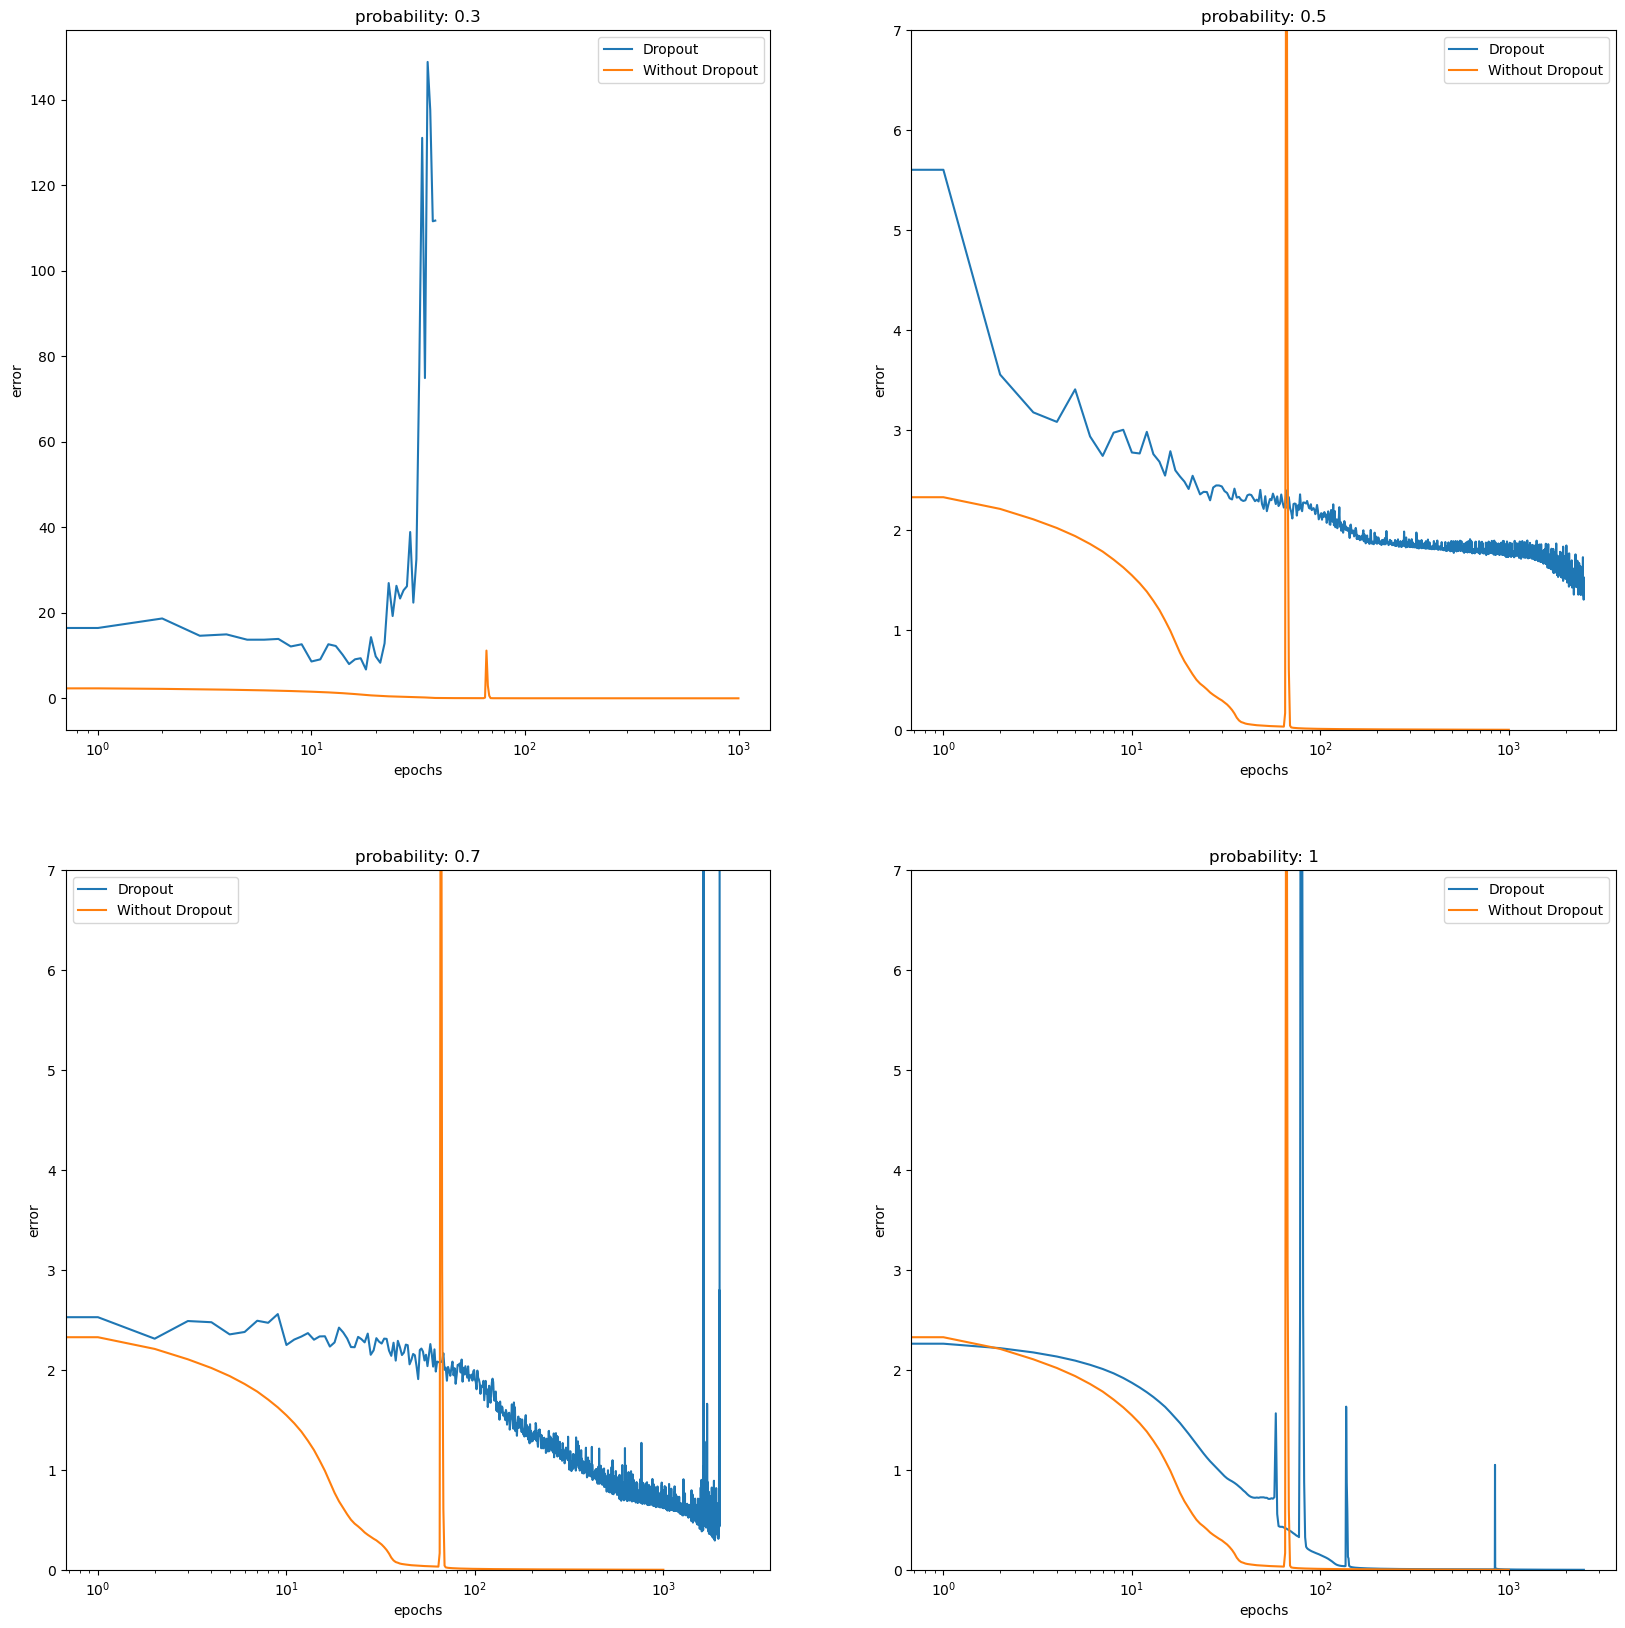

In [37]:
# Plot error for epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

plt.subplot(2,2,1)
plt.semilogx(range(len(net1.error)), net1.error)
plt.semilogx(range(len(normal.error)), normal.error)
plt.title('probability: 0.3')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend(['Dropout', 'Without Dropout'])

plt.subplot(2,2,2)
plt.semilogx(range(len(net2.error)), net2.error)
plt.semilogx(range(len(normal.error)), normal.error)
plt.title('probability: 0.5')
plt.xlabel('epochs')
plt.ylabel('error')
plt.ylim(0, 7)
plt.legend(['Dropout', 'Without Dropout'])

plt.subplot(2,2,3)
plt.semilogx(range(len(net3.error)), net3.error)
plt.semilogx(range(len(normal.error)), normal.error)
plt.title('probability: 0.7')
plt.xlabel('epochs')
plt.ylabel('error')
plt.ylim(0, 7)
plt.legend(['Dropout', 'Without Dropout'])

plt.subplot(2,2,4)
plt.semilogx(range(len(net4.error)), net4.error)
plt.semilogx(range(len(normal.error)), normal.error)
plt.title('probability: 1')
plt.xlabel('epochs')
plt.ylabel('error')
plt.ylim(0, 7)
plt.legend(['Dropout', 'Without Dropout'])

plt.show()



## Dropout probability의 변화
dropout확률이 낮을 수록 dropout레이어가 무시되는 비율이 줄어들기 때문에 모델의 과적합 경향이 높아지고 낮아질 수록 dropout 레이어가 무시하는 비율이 증가하여 과소적합이 되기 쉬워지므로 위 와 같은 그래프 형태를 띠게 된다.


## 과적합

학습 데이터에 지나치게 fit된 모델이 새로운 데이터에 대해 예측 성능이 떨어지는 현상

## 과소적합

모델이 복잡도가 부족하거나 학습데이터가 충분하지 않은 경우에 발생

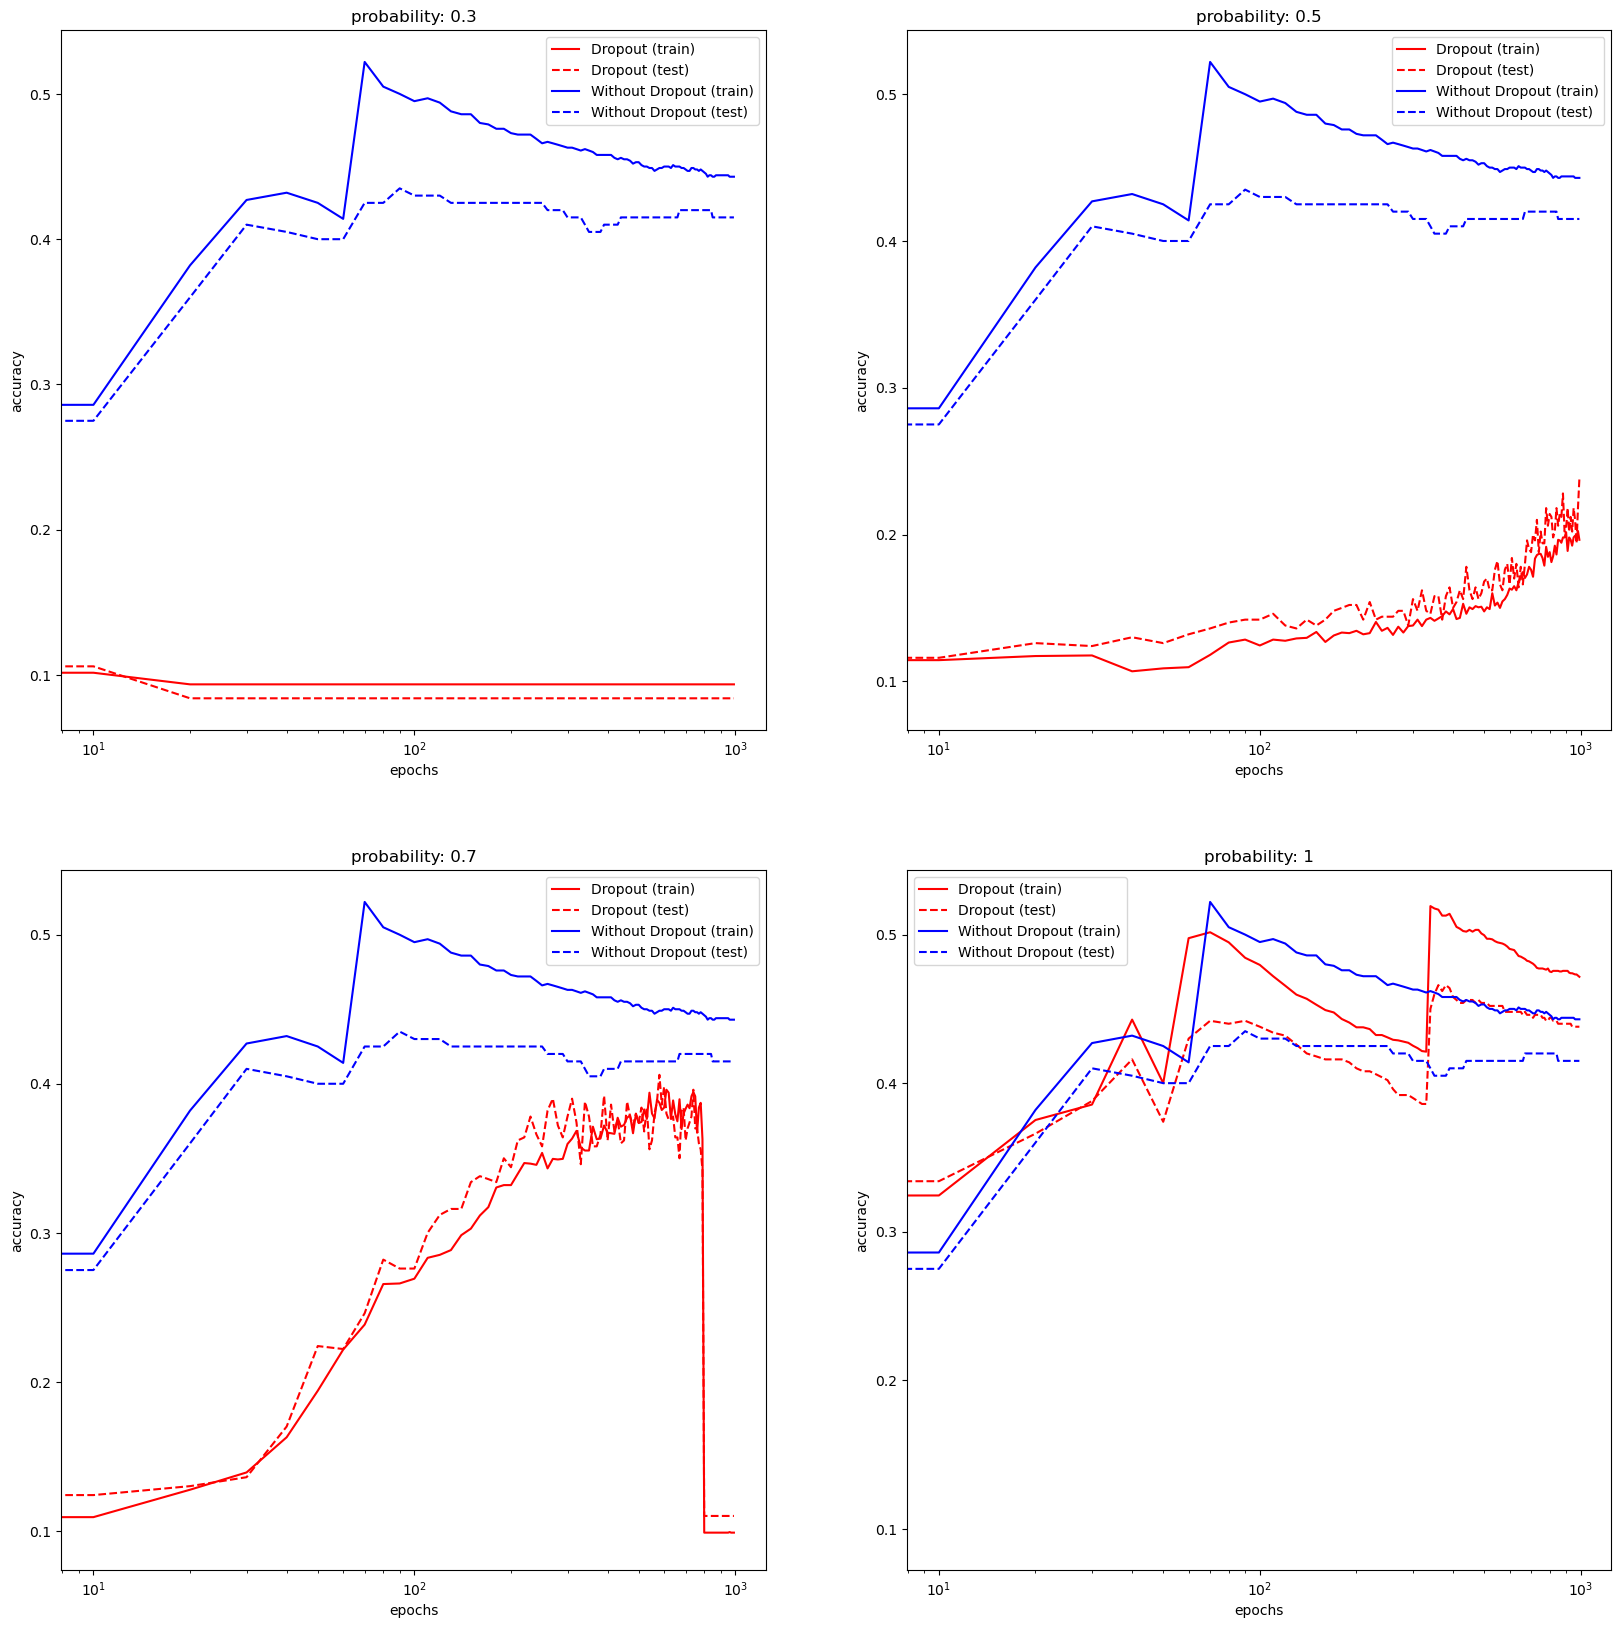

In [39]:
# Plot accuracy for epochs
steps = 10

plt.figure(figsize=(20, 20))

plt.subplot(2,2,1)
plt.semilogx(range(0, steps*len(net1.accu_train), steps), net1.accu_train, 'r')
plt.semilogx(range(0, steps*len(net1.accu_test), steps), net1.accu_test, 'r--')
plt.semilogx(range(0, steps*len(normal.accu_train), steps), normal.accu_train, 'b')
plt.semilogx(range(0, steps*len(normal.accu_test), steps), normal.accu_test, 'b--')
plt.title('probability: 0.3')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Dropout (train)', 'Dropout (test)', 'Without Dropout (train)', 'Without Dropout (test)'])

plt.subplot(2,2,2)
plt.semilogx(range(0, steps*len(net2.accu_train), steps), net2.accu_train, 'r')
plt.semilogx(range(0, steps*len(net2.accu_test), steps), net2.accu_test, 'r--')
plt.semilogx(range(0, steps*len(normal.accu_train), steps), normal.accu_train, 'b')
plt.semilogx(range(0, steps*len(normal.accu_test), steps), normal.accu_test, 'b--')
plt.title('probability: 0.5')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Dropout (train)', 'Dropout (test)', 'Without Dropout (train)', 'Without Dropout (test)'])

plt.subplot(2,2,3)
plt.semilogx(range(0, steps*len(net3.accu_train), steps), net3.accu_train, 'r')
plt.semilogx(range(0, steps*len(net3.accu_test), steps), net3.accu_test, 'r--')
plt.semilogx(range(0, steps*len(normal.accu_train), steps), normal.accu_train, 'b')
plt.semilogx(range(0, steps*len(normal.accu_test), steps), normal.accu_test, 'b--')
plt.title('probability: 0.7')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Dropout (train)', 'Dropout (test)', 'Without Dropout (train)', 'Without Dropout (test)'])

plt.subplot(2,2,4)
plt.semilogx(range(0, steps*len(net4.accu_train), steps), net4.accu_train, 'r')
plt.semilogx(range(0, steps*len(net4.accu_test), steps), net4.accu_test, 'r--')
plt.semilogx(range(0, steps*len(normal.accu_train), steps), normal.accu_train, 'b')
plt.semilogx(range(0, steps*len(normal.accu_test), steps), normal.accu_test, 'b--')
plt.title('probability: 1')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Dropout (train)', 'Dropout (test)', 'Without Dropout (train)', 'Without Dropout (test)'])

